In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib as mpl
from sklearn.decomposition import PCA
from src.feature_extraction import scale_density, split_data, scale_population_curves
from src.cluster_data import *
from sklearn.metrics import accuracy_score
import pandas as pd
import seaborn as sns
import plotly.express as px
import yaml
from src.feature_extraction import compile_data

# Density

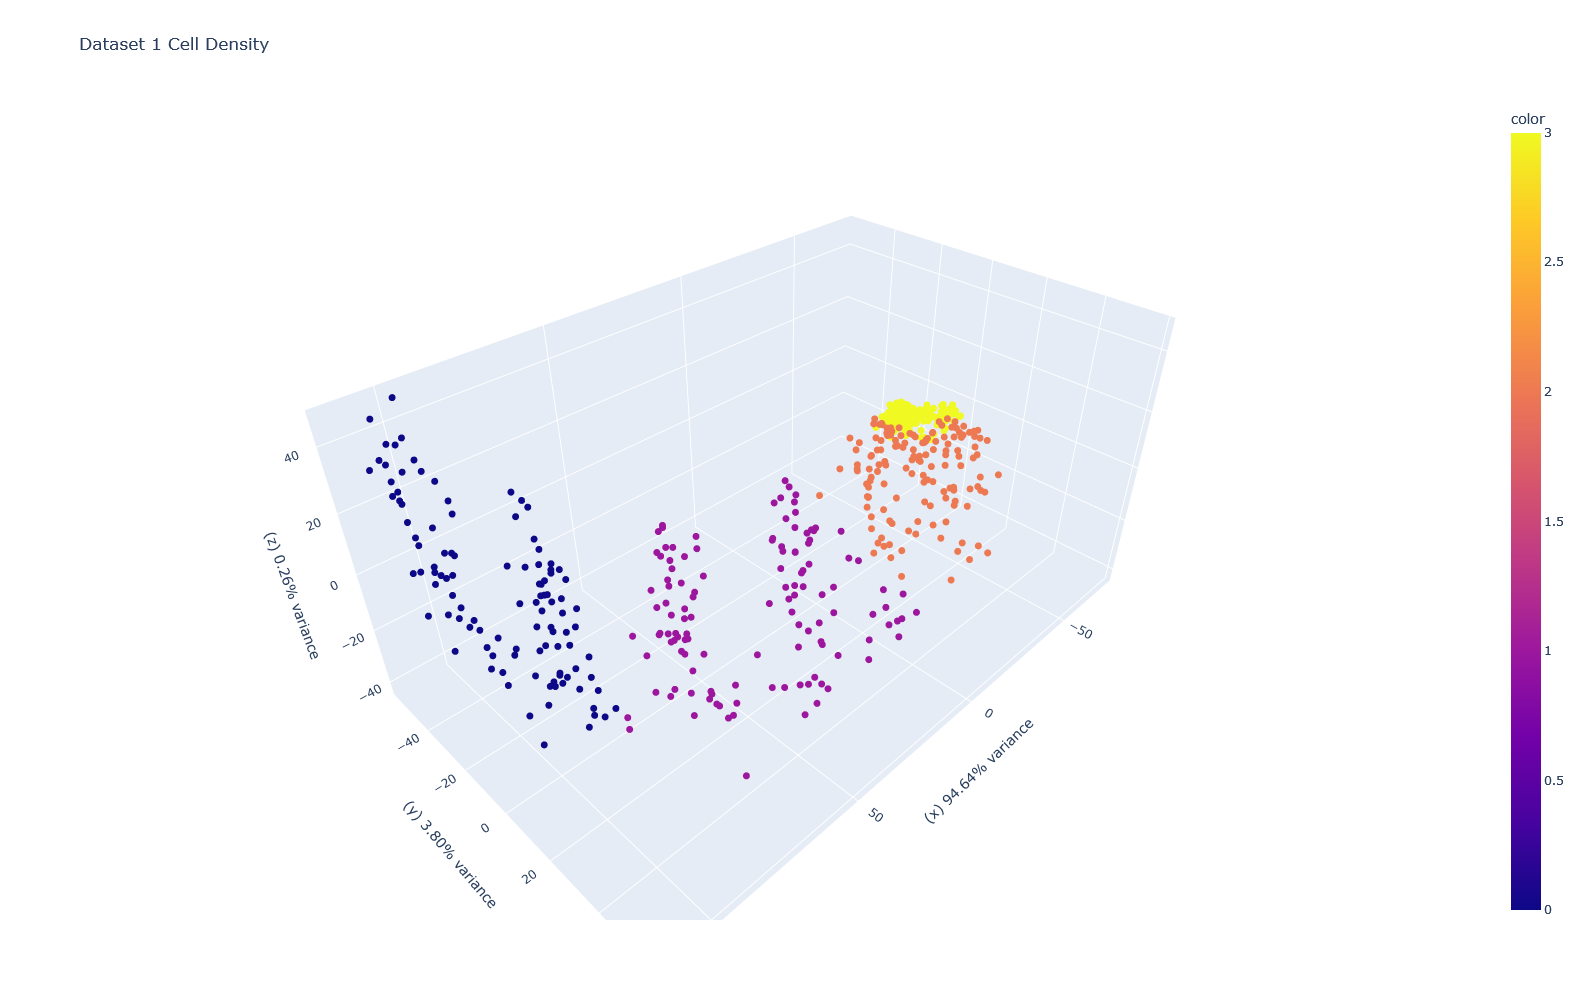

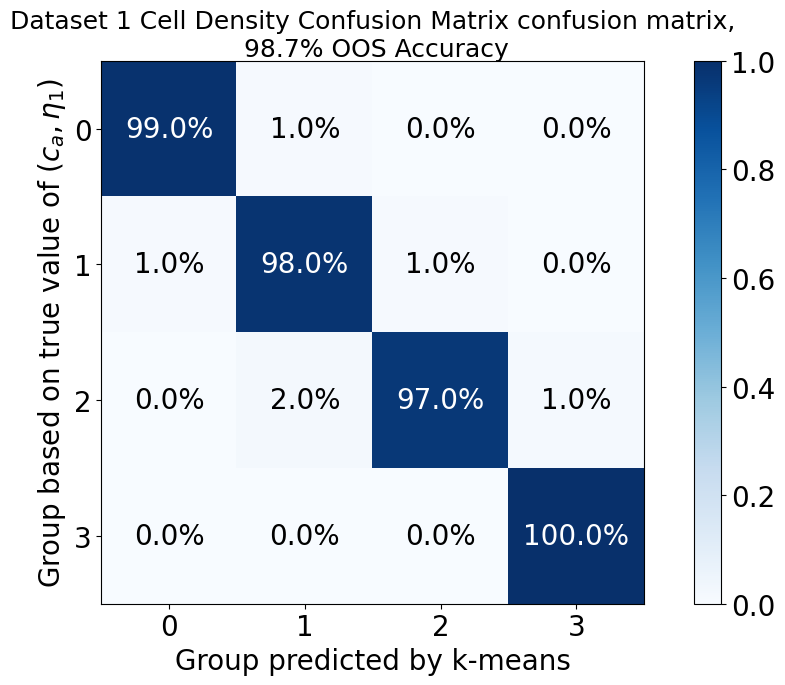

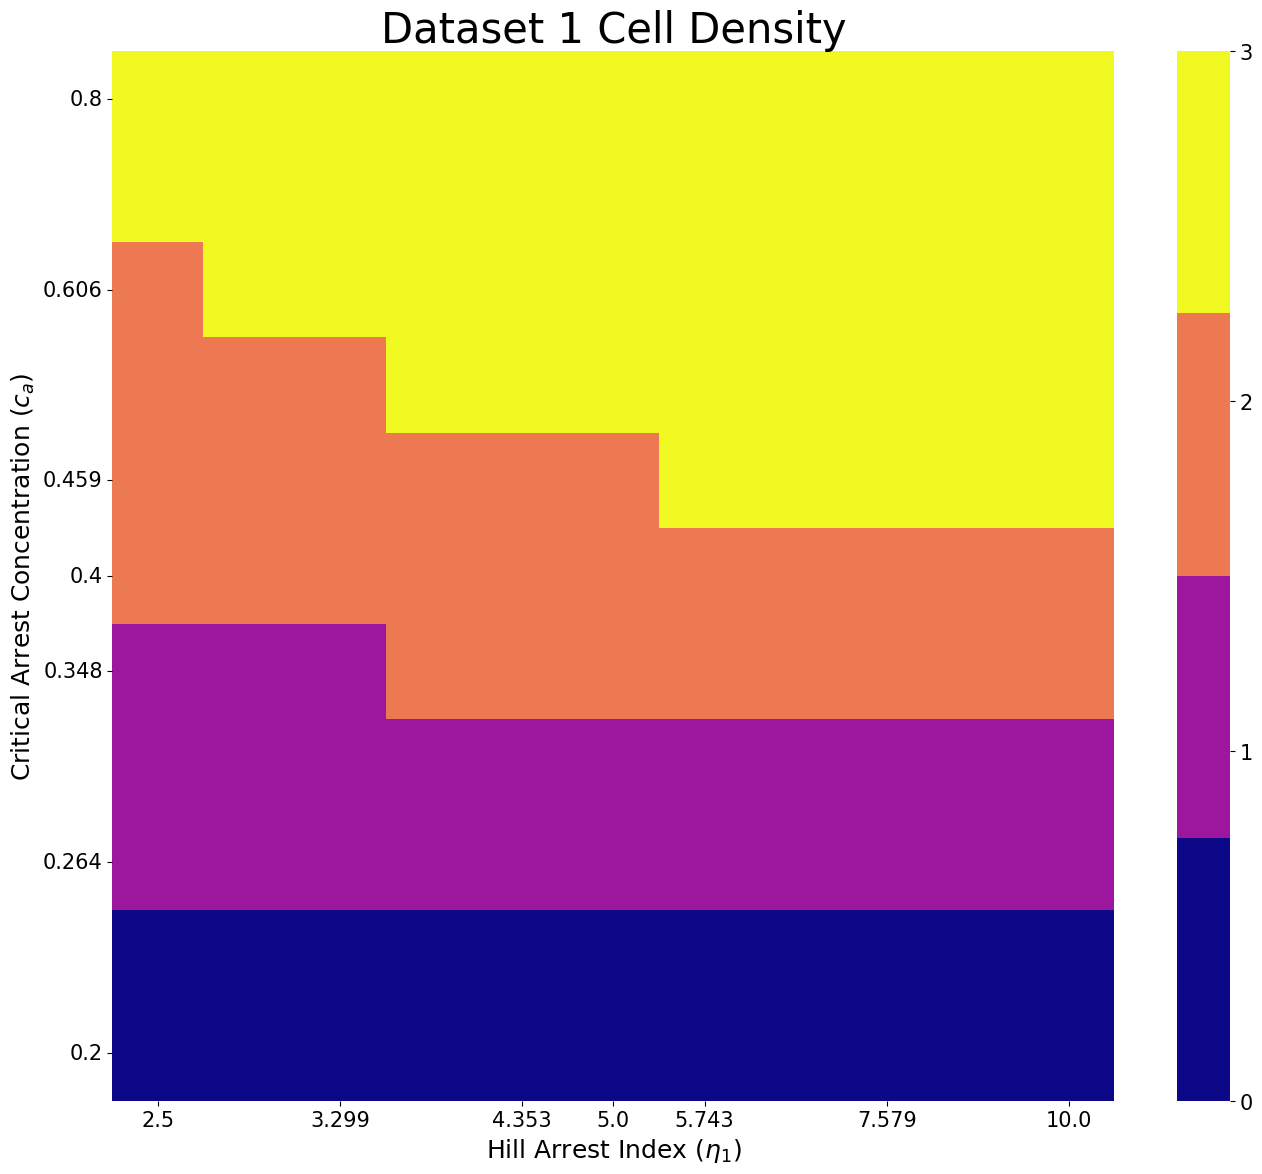

In [14]:
# Load, Split, Scale data
density = np.load("../data/dataset1/density.npy", allow_pickle=True)
density_train, density_test = split_data(density, itr_cutoff = 5)


density_train = scale_density(density_train).reshape((605,40000))
density_test = scale_density(density_test).reshape((605,40000))


# Reduce dimensions to 3
density_pca = PCA(n_components = 3, random_state = 0)
density_pca.fit(density_train)
density_train_reduced = density_pca.transform(density_train)
density_test_reduced = density_pca.transform(density_test)
# Cluster
density_kmeans = KMeans(n_clusters = 4,n_init = 'auto', random_state = None)
    
density_kmeans.fit(density_train_reduced)
density_train_labels = density_kmeans.predict(density_train_reduced)
density_predicted_test_labels = density_kmeans.predict(density_test_reduced)



param_ranges = {"(c_a,eta1)" : np.array([()])}
    
c_a_base = 0.4
eta1_base = 5
num_clusters = 4
    
param_labels, _ = generate_param_labels(param_ranges, labels = {'(c_a,eta1)' : density_train_labels.reshape((121,5))}, n_iterations = 5, n_param_value_combos = 121)
common_label = param_labels['(c_a,eta1)'].reshape((11,11))
eta1_vec = np.round(np.logspace(np.log2(eta1_base / 2), np.log2(2 * eta1_base), 11, base = 2),3)
c_a_vec = np.round(np.logspace(np.log2(c_a_base / 2), np.log2(2 * c_a_base), 11, base = 2),3)
    
classes, order = np.unique(common_label, return_index = True)

    
common_label_copy = np.zeros(common_label.shape)
density_train_labels_copy = np.zeros(density_train_labels.shape)
density_predicted_test_labels_copy = np.zeros(density_predicted_test_labels.shape)

for inew, iold in enumerate(np.argsort(order)):
    common_label_copy[common_label == iold] = inew
    density_train_labels_copy[density_train_labels == iold] = inew
    density_predicted_test_labels_copy[density_predicted_test_labels == iold] = inew


common_label_copy = common_label_copy.reshape(121)
common_label = common_label.reshape(121)

pca_fig = px.scatter_3d(x=density_train_reduced[:, 0],
                        y=density_train_reduced[:, 1],
                        z=density_train_reduced[:, 2],
                        color=density_train_labels_copy, labels = {'x': f"(x) {100*var[0]:.2f}% variance",
                                                              'y': f"(y) {100*var[1]:.2f}% variance",
                                                              'z':f"(z) {100*var[2]:.2f}% variance"},
                        title = "Dataset 1 Cell Density")

pca_fig.update_traces(marker={'size': 4})
pca_fig.update_layout(autosize=False,
                             width = 1200,
                             height = 1000)
     
pca_fig.show()


oos = accuracy_score(np.repeat(param_labels['(c_a,eta1)'], 5), density_predicted_test_labels_copy)



cm = generate_confusion_matrix(np.repeat(common_label_copy, 5), density_predicted_test_labels_copy, n_clusters = 4)
cm_fig = plot_confusion_matrix_and_OOS(confusion_matrix = cm,
                                       y_true = np.repeat(common_label_copy, 5),
                                       y_pred = density_predicted_test_labels_copy,
                                       n_clusters = 4,
                                       xlabel = "Group predicted by k-means",
                                       ylabel = "Group based on true value of $(c_a, \eta_1)$",
                                       title = "Dataset 1 Cell Density");    



cm_fig.savefig("../figures/dataset1/density_confusion_matrix.png")
heat_fig = plt.figure(figsize = (14, 12))

col1 = np.repeat(c_a_vec,11)
col2 = np.tile(eta1_vec,11)


d = {'c_a': col1, 'eta1': col2, 'Cluster': common_label_copy}
df = pd.DataFrame(data=d)
piv_df = df.pivot(index='c_a', columns='eta1', values='Cluster')

plasma = mpl.colormaps['plasma'].resampled(num_clusters)


tick_inds = [i for i in range(len(c_a_vec))]
tick_inds = tick_inds[::2]
tick_inds.append(5)
    
heat_ax = heat_fig.add_subplot(111)
plt.rcParams.update({'font.size': 15})
sns.heatmap(piv_df, cmap = plasma, ax = heat_ax, cbar_kws={'ticks': [i for i in range(num_clusters)]})
heat_ax.set_yticks(heat_ax.get_yticks()[tick_inds])
heat_ax.set_xticks(heat_ax.get_xticks()[tick_inds])
heat_ax.set_yticklabels(c_a_vec[tick_inds],rotation = 0, fontsize = 15)
heat_ax.set_xticklabels(eta1_vec[tick_inds],rotation = 0, fontsize = 15)
heat_ax.invert_yaxis()
heat_ax.set_title("Dataset 1 Cell Density", fontsize = 30)
heat_ax.set_xlabel("Hill Arrest Index ($\eta_1$)",fontsize=18)
heat_ax.set_ylabel("Critical Arrest Concentration ($c_a$)",fontsize=18)
heat_fig.tight_layout()
heat_fig.savefig("../figures/dataset1/density_parameter_partition.png")

# Cell Counts

Cell Counts: Cumulative Explained Variance = 98.71%
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2.]
 [1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3.]
 [2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3.]
 [2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]]


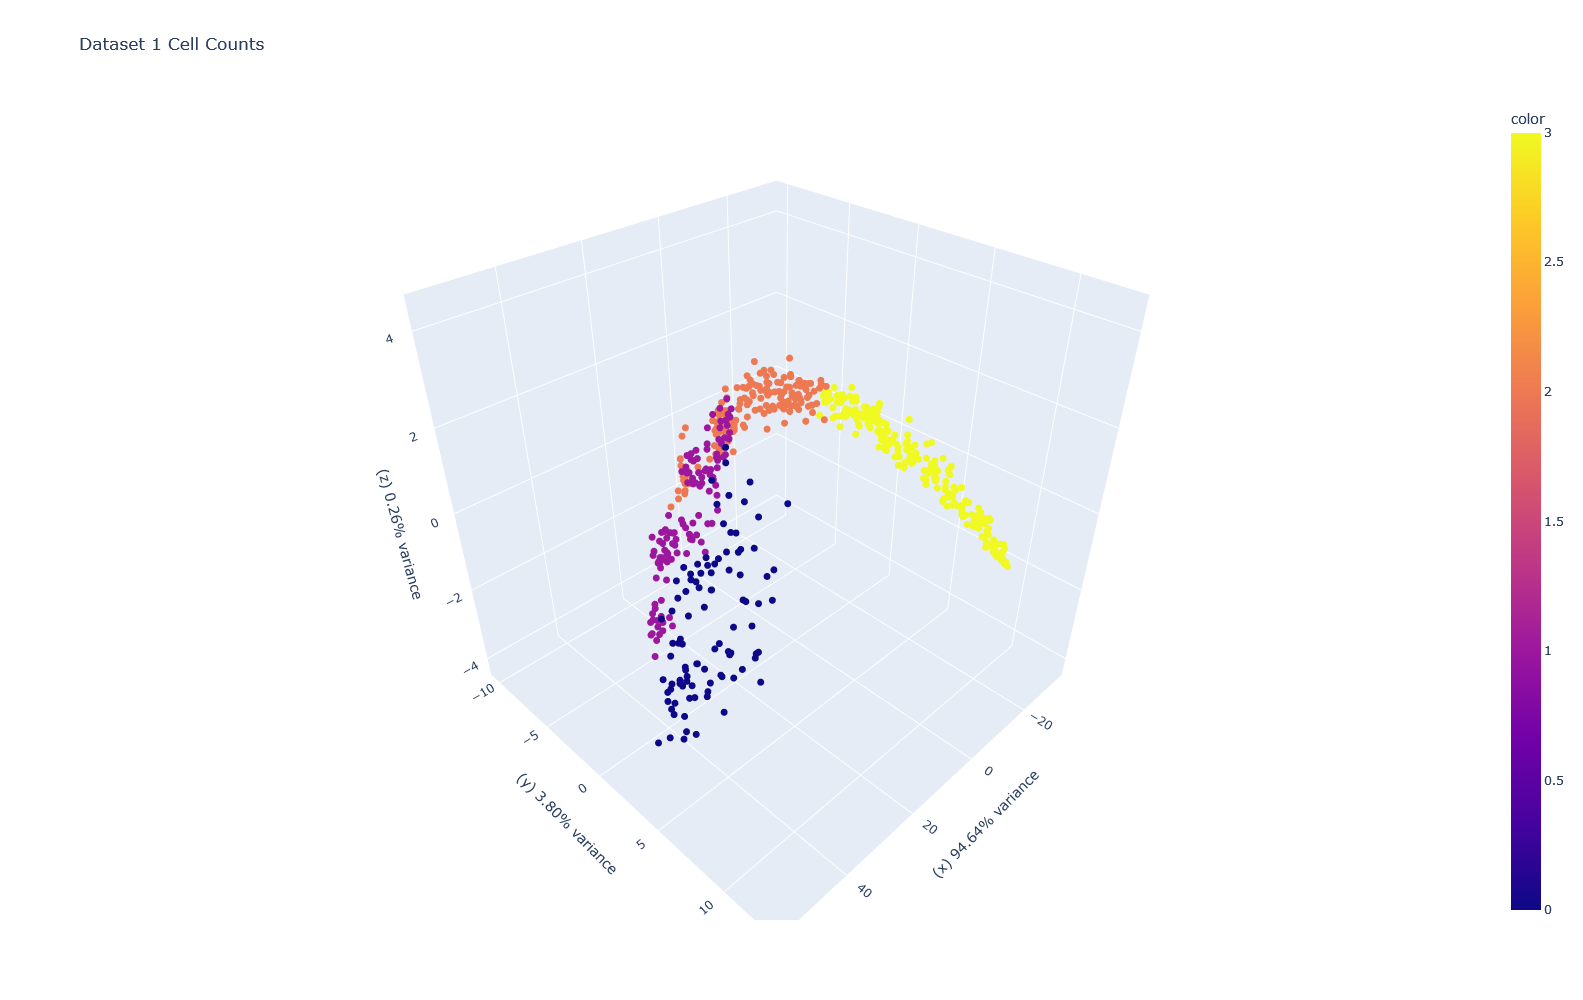

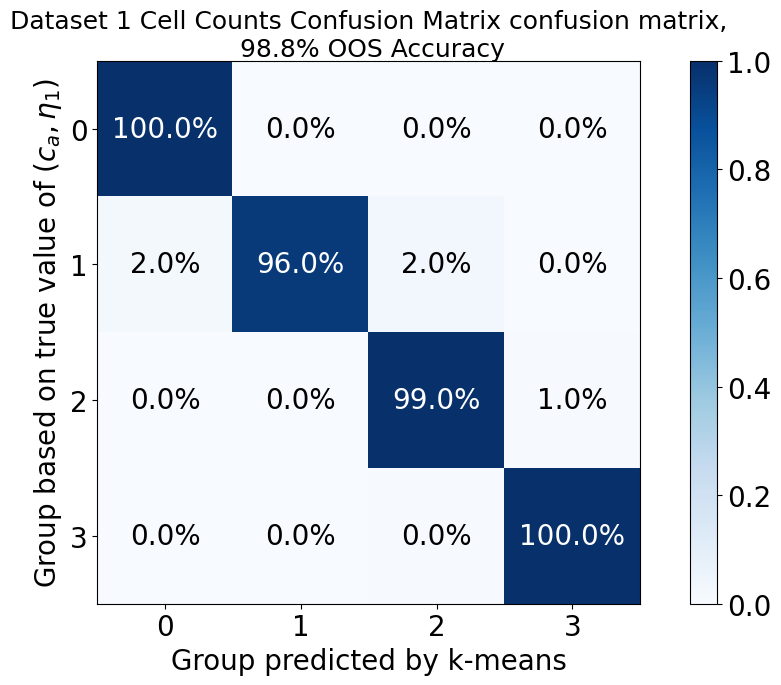

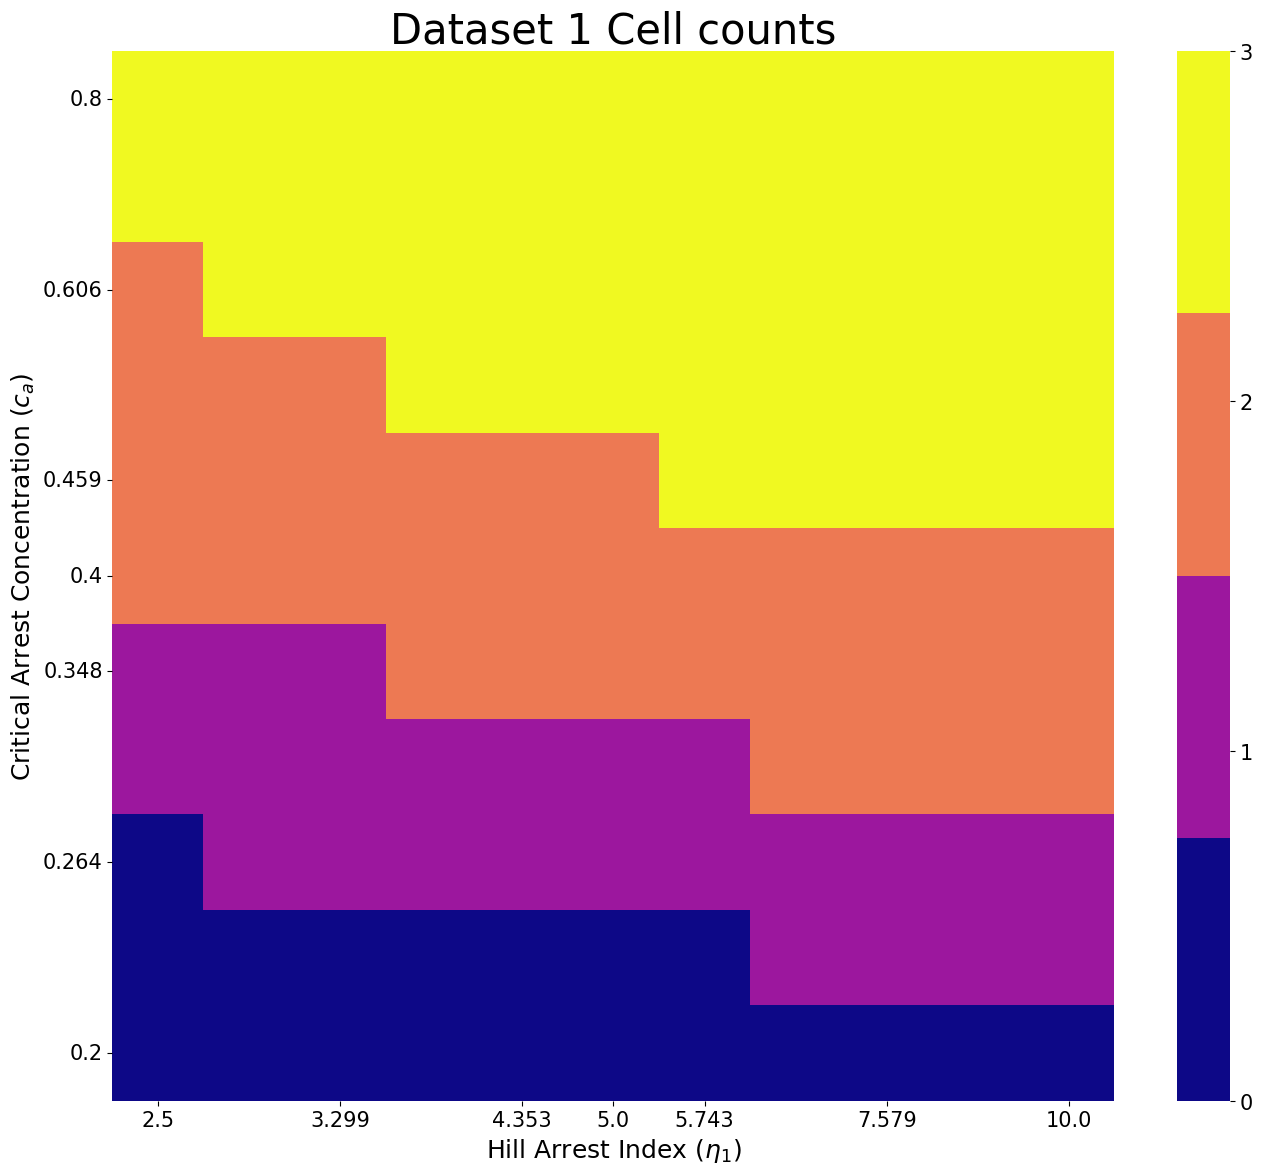

In [13]:

## Load, Split, Scale data
counts = np.load("../data/dataset1/cell_counts.npy", allow_pickle=True)
counts_train, counts_test = split_data(counts, itr_cutoff = 5)


counts_train = scale_population_curves(counts_train).reshape((605,4*241))
counts_test = scale_population_curves(counts_test).reshape((605,4*241))


## Reduce dimensions to 3
counts_pca = PCA(n_components = 3, random_state = 0)
counts_pca.fit(counts_train)
counts_train_reduced = counts_pca.transform(counts_train)
counts_test_reduced = counts_pca.transform(counts_test)
var = counts_pca.explained_variance_ratio_
print(f"Cell Counts: Cumulative Explained Variance = {100*np.sum(var[:3]):.2f}%")



# Cluster
counts_kmeans = KMeans(n_clusters = 4,n_init = 'auto', random_state = None)
    
counts_kmeans.fit(counts_train_reduced)
counts_train_labels = counts_kmeans.predict(counts_train_reduced)
counts_predicted_test_labels = counts_kmeans.predict(counts_test_reduced)


param_ranges = {"(c_a,eta1)" : np.array([()])}
    
c_a_base = 0.4
eta1_base = 5
num_clusters = 4
    
param_labels, _ = generate_param_labels(param_ranges, labels = {'(c_a,eta1)' : counts_train_labels.reshape((121,5))}, n_iterations = 5, n_param_value_combos = 121)
common_label = param_labels['(c_a,eta1)'].reshape((11,11))
eta1_vec = np.round(np.logspace(np.log2(eta1_base / 2), np.log2(2 * eta1_base), 11, base = 2),3)
c_a_vec = np.round(np.logspace(np.log2(c_a_base / 2), np.log2(2 * c_a_base), 11, base = 2),3)
    
classes, order = np.unique(common_label, return_index = True)

    
common_label_copy = np.zeros(common_label.shape)
counts_train_labels_copy = np.zeros(counts_train_labels.shape)
counts_predicted_test_labels_copy = np.zeros(counts_predicted_test_labels.shape)

for inew, iold in enumerate(np.argsort(order)):
    common_label_copy[common_label == iold] = inew
    counts_train_labels_copy[counts_train_labels == iold] = inew
    counts_predicted_test_labels_copy[counts_predicted_test_labels == iold] = inew


common_label_copy = common_label_copy.reshape(121);
common_label = common_label.reshape(121);

pca_fig = px.scatter_3d(x=counts_train_reduced[:, 0],
                        y=counts_train_reduced[:, 1],
                        z=counts_train_reduced[:, 2],
                        color=counts_train_labels_copy, labels = {'x': f"(x) {100*var[0]:.2f}% variance",
                                                              'y': f"(y) {100*var[1]:.2f}% variance",
                                                              'z':f"(z) {100*var[2]:.2f}% variance"},
                        title = "Dataset 1 Cell Counts")

pca_fig.update_traces(marker={'size': 4})
pca_fig.update_layout(autosize=False,
                             width = 1200,
                             height = 1000)
     
pca_fig.show()


oos = accuracy_score(np.repeat(param_labels['(c_a,eta1)'], 5), counts_predicted_test_labels_copy)



cm = generate_confusion_matrix(np.repeat(common_label_copy, 5), counts_predicted_test_labels_copy, n_clusters = 4)
cm_fig = plot_confusion_matrix_and_OOS(confusion_matrix = cm,
                                       y_true = np.repeat(common_label_copy, 5),
                                       y_pred = counts_predicted_test_labels_copy,
                                       n_clusters = 4,
                                       xlabel = "Group predicted by k-means",
                                       ylabel = "Group based on true value of $(c_a, \eta_1)$",
                                       title = "Dataset 1 Cell Counts");   



cm_fig.savefig("../figures/dataset1/cell_counts_confusion_matrix.png")
heat_fig = plt.figure(figsize = (14, 12))

col1 = np.repeat(c_a_vec,11)
col2 = np.tile(eta1_vec,11)


d = {'c_a': col1, 'eta1': col2, 'Cluster': common_label_copy}
df = pd.DataFrame(data=d)
piv_df = df.pivot(index='c_a', columns='eta1', values='Cluster')

plasma = mpl.colormaps['plasma'].resampled(num_clusters)


tick_inds = [i for i in range(len(c_a_vec))]
tick_inds = tick_inds[::2]
tick_inds.append(5)
    
heat_ax = heat_fig.add_subplot(111)
plt.rcParams.update({'font.size': 15})
sns.heatmap(piv_df, cmap = plasma, ax = heat_ax, cbar_kws={'ticks': [i for i in range(num_clusters)]})
heat_ax.set_yticks(heat_ax.get_yticks()[tick_inds])
heat_ax.set_xticks(heat_ax.get_xticks()[tick_inds])
heat_ax.set_yticklabels(c_a_vec[tick_inds],rotation = 0, fontsize = 15)
heat_ax.set_xticklabels(eta1_vec[tick_inds],rotation = 0, fontsize = 15)
heat_ax.invert_yaxis()
heat_ax.set_title("Dataset 1 Cell counts", fontsize = 30)
heat_ax.set_xlabel("Hill Arrest Index ($\eta_1$)",fontsize=18)
heat_ax.set_ylabel("Critical Arrest Concentration ($c_a$)",fontsize=18)
heat_fig.tight_layout()
heat_fig.savefig("../figures/dataset1/cell_counts_parameter_partition.png")